In [ ]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
import time
from os import listdir
import functools
import pickle
import math
from IPython import display as ipythondisplay
from tqdm import tqdm

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4775819674730741877
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5824541131957901818
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15727479690101278927
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1126873379061130296
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()



In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model


In [ ]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss


In [ ]:
# for House music change 'balladArr.pkl' to houseArr.pkl (and also change the path to where you put it in your google drive), for poprock it is poprockArr.pkl
infile = open('/content/drive/My Drive/MusicData/balladArr.pkl','rb')
#likewise, change the name ballad here to house or poprock
ballad = pickle.load(infile)
infile.close()
ballad

,0,1,2,3
0,0 1 2 3 0 0.076...,0 1 2 3 0 0.076...,0 1 2 3 0 0.07616...,0 1 2 3 0 0.31393...
1,0 1 2 3 0 0.40344...,0 1 2 3 0 0.1277...,0 1 2 3 0 0.678303...,0 1 2 3 0 0.95346...
2,0 1 2 3 0 0.0663...,0 1 2 3 0 1.9372...,0 1 2 3 0 0.0663...,0 1 2 3 0 1.93720...
3,0 1 2 3 0 0.046...,0 1 2 3 0 0.917187...,0 1 2 3 0 15.0398...,0 1 2 3 0 0.05224...
4,0 1 2 3 0 0.3419...,0 1 2 3 0 0.3757...,0 1 2 3 0 0.3715...,0 1 2 3 0 0.341966...
...,...,...,...,...
7050,0 1 2 3 0 0.069...,0 1 2 3 0 3.078961 ...,0 1 2 3 0 3.016988 ...,0 1 2 3 0 0.07585...
7051,0 1 2 3 0 0.213...,0 1 2 3 0 0.050538...,0 1 2 3 0 1.87535...,0 1 2 3 0 0.213077...
7052,0 1 2 3 0 0.325...,0 1 2 3 0 0.0232...,0 1 2 3 0 0.023220...,0 1 2 3 0 0.325079...
7053,0 1 2 3 0 0.007...,0 1 2 3 0 0.775995...,0 1 2 3 0 0.0074...,0 1 2 3 0 0.19924...


In [ ]:
ballad = ballad.reindex(np.random.permutation(ballad.index))
testSize = int(len(ballad) * .15)
testSet = ballad[:testSize].reset_index(drop=True)
ballad = ballad[testSize:].reset_index(drop=True)
ballad

,0,1,2,3
0,0 1 2 3 0 0.510...,0 1 2 3 0 0.743...,0 1 2 3 0 0.743...,0 1 2 3 0 0.74303...
1,0 1 2 3 0 0.0541...,0 1 2 3 0 3.088252 ...,0 1 2 3 0 0.0541...,0 1 2 3 0 0.054180...
2,0 1 2 3 0 0.012...,0 1 2 3 0 0.3328...,0 1 2 3 0 0.0126...,0 1 2 3 0 0.012...
3,0 1 2 3 0 0.0476...,0 1 2 3 0 0.04167...,0 1 2 3 0 0.068...,0 1 2 3 0 0.22853...
4,0 1 2 3 0 0.33281...,0 1 2 3 0 1.23220...,0 1 2 3 0 8.825169 ...,0 1 2 3 0 0.63313...
...,...,...,...,...
5992,0 1 2 3 0 0.0154...,0 1 2 3 0 16.9853...,0 1 2 3 0 0.0247...,0 1 2 3 0 0.59752...
5993,0 1 2 3 0 0.0571...,0 1 2 3 0 0.0571...,0 1 2 3 0 0.0571...,0 1 2 3 0 0.27863...
5994,0 1 2 3 0 0.078...,0 1 2 3 0 22.437240 ...,0 1 2 3 0 4.621...,0 1 2 3 0 0.078...
5995,0 1 2 3 0 1.394...,0 1 2 3 0 0.028...,0 1 2 3 0 2.755...,0 1 2 3 0 2.41487...


In [ ]:

def encode_notes_full(notesArr):
    size = math.ceil(notesArr[-1:][1])
    sizeF = size*4
    mod = sizeF%batchSize
    pad = 0
    if(mod != 0):
         pad = batchSize - mod
    encodeNotes =  pd.DataFrame([[0.0]*30]*(sizeF+pad))
    length = len(notesArr)
    count = 0
    partInt=0
    for i in range(length):
        start = notesArr[0][i]
        count = 0
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt)*4
        if(part<=0.25):
            partInt = 0
        elif(0.25<part<=0.5):
            partInt = 1
        elif(0.5<part<=0.75):
            partInt = 2
        elif(0.75<part<=1.0):
            partInt = 3
        #print(partInt)
        for j in range(29):
            if(encodeNotes[j][index + partInt]==0.0 and encodeNotes[j+1][index + partInt]==0.0 and encodeNotes[j+2][index + partInt]==0.0):
                #print('here')
                encodeNotes[j][index + partInt] = dur
                encodeNotes[j+1][index + partInt] = notesArr[2][i]
                encodeNotes[j+2][index + partInt] = notesArr[3][i]
                break
    return encodeNotes

In [ ]:
def cut_output(y_hat, instrument ):
    if(instrument=='drums'):
      y_hat = y_hat[:,0:30]
    if(instrument=='piano'):
      y_hat = y_hat[:,30:60]
    if(instrument=='guitar'):
      y_hat = y_hat[:,60:90]
    if(instrument=='bass'):
      y_hat = y_hat[:,90:120]
    return y_hat

In [ ]:
modelF = build_model(200, embedding_dim=512, rnn_units=2048, batch_size=60)

In [ ]:

def get_encoded_song( songNum, instrument):
    drums = encode_notes_full(ballad[0][songNum])
    piano = encode_notes_full(ballad[1][songNum])
    guitar = encode_notes_full(ballad[2][songNum])
    bass = encode_notes_full(ballad[3][songNum])
    fullSong = pd.concat([drums, piano, guitar, bass], axis=1, sort=False)
    fullSong.fillna(0.0, inplace=True)
    if(instrument=='drums'):
        drums.fillna(0.0, inplace=True)
        return fullSong, drums
    if(instrument=='piano'):
        piano.fillna(0.0, inplace=True)
        return fullSong, piano
    if(instrument=='guitar'):
        guitar.fillna(0.0, inplace=True)
        return fullSong, guitar
    if(instrument=='bass'):
        bass.fillna(0.0, inplace=True)
        return fullSong, bass
    

In [ ]:
def get_batchF(encodedNotes, encodedIns1, iteration, batchSize):

    idx = int(iteration * batchSize)
    input_batch = encodedNotes[idx:(idx+batchSize)].values
    output_batch = encodedIns1[(idx+batchSize):(idx+(batchSize*2))].values
    output_batch[output_batch > 200] = 200
    output_batch[output_batch < 0] = 0
    input_batch[input_batch > 200] = 200
    input_batch[input_batch < 0] = 0
    return input_batch, output_batch

In [ ]:

num_training_iterations = 4*len(ballad)
learning_rate = 5e-3 
#genreCleaned= house
instrument = 'bass'
totalSongs = len(ballad)-1
batchSize = 60
checkpoint_dir = '/content/drive/My Drive/MusicData/balladBass' 
checkpoint_prefix = os.path.join(checkpoint_dir, "balladBass")
iteration_restart = 0

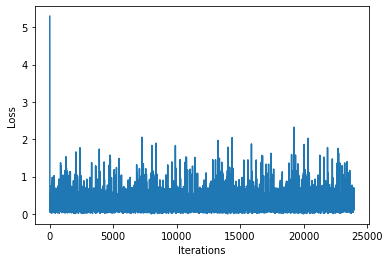

100%|██████████| 23988/23988 [3:48:45<00:00,  1.75it/s]


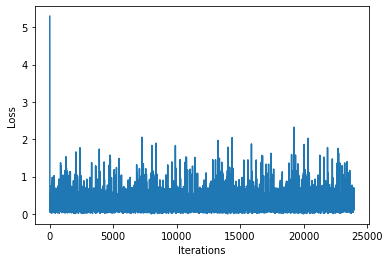

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    y_hat = modelF(x) 
    y_hat = cut_output(y_hat, instrument)
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, modelF.trainable_variables) 
  
  optimizer.apply_gradients(zip(grads, modelF.trainable_variables))
  return loss

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
  if (iteration_restart<=iter):
      if (iter>totalSongs):
          songNum = iter%totalSongs
      else: 
          songNum = iter
      
      song, ins = get_encoded_song(songNum, instrument)
      
      for j in range(int(min((len(song)/batchSize)-1,int((len(ins)/batchSize)-1)))):
          print(j)
          x_batch, y_batch = get_batchF(song, ins, j, batchSize)
          loss = train_step(x_batch, y_batch)
          
      history.append(loss.numpy().mean())
      plotter.plot(history)

      if(iter % 100 == 0):     
              print('Saved')
              modelF.save_weights(checkpoint_prefix)
      

modelF.save_weights(checkpoint_prefix)

In [ ]:
len(house)*2

6426

In [ ]:
song, ins = get_encoded_song( 7, 'drums')
len(ins)/120




3.0

In [ ]:
x_batch, y_batch = get_batchF(song, ins, 2)
y_batch[105,120]

0.0

In [ ]:
y_batch[y_batch > 200] = 200

In [ ]:
y_batch[y_batch < 0] = 0

In [ ]:
x_batch[105,120]

0.0